# Setup

In [2]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [3]:
from setup import *

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/09 17:27:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load regions

In [5]:
indy = Region.load('Indianapolis', 'Indiana')
aus = Region.load('Austin', 'Texas')
hous = Region.load('Houston', 'Texas')

# Prepare pings

In [8]:
def prepare_pings(rgn, dates, max_error=50, save=False):
    minx, miny, maxx, maxy = rgn.bbox
    if isinstance(dates, dt.date): dates = [dates]
    for date in tqdm(dates):
        try:
            # read the data and zip the pings
            path = QUADRANT + rgn.state.title() + '/' + date.strftime('%Y/%m/%d')
            df = SP.read_parquet(path)
            df = mk.gps.zip_pings(df, col='pings')
            # filter pings within bounding box & 
            # within spatial error threshold
            def filt_error(p): 
                return [x for x in p if x[ERR] <= max_error and 
                        minx <= x[LON] <= maxx and miny <= x[LAT] <= maxy]
            dtype = df.schema['pings'].dataType
            df = df.withColumn('pings', F.udf(filt_error, dtype)('pings'))
            df = df.filter(F.size('pings') > 0)
            df = mk.gps.unzip_pings(df)
            if save:
                path = rgn.data + 'pings/' + date.strftime('%Y-%m-%d')
                mk.spark.write(df, path)
        except Exception as e:
            print(date, '\n'.join(str(e).split('\n')[:5]))
    P.params.set('pings.max_error', max_error)\
    .set(f'regions.{rgn}.ping_dates', f'{dates[0]} - {dates[-1]}')
    return df

# df = prepare_pings(indy, dt.date(2021, 3, 1)); df

In [ ]:
# %time prepare_pings(indy, U.dates('2021-03-01', '2021-03-15'), save=False) # t=8:32
# %time prepare_pings(aus, U.dates('2021-07-01', '2021-07-15'), save=False) # t=20:06
# %time prepare_pings(hous, U.dates('2021-07-01', '2021-07-15'), save=False) # t=47:51 (TNET)

# Compute user stats

## Ping counts by half-hour slot

In [10]:
def get_ping_counts(rgn, dates=None, save=False):
    res = []
    def get_slot(t):
        return [int(x / (3600 * 0.5)) for x in t]
    def count(slots):
        return {int(k): int(v) for k, v in zip(*np.unique(slots, return_counts=True))}
    if dates is None:
        dates = pd.to_datetime([f.split('/')[-1] for f in glob(rgn.data + 'pings/*')]).date
    for d in dates:
        df = SP.read_parquet(rgn.data + f'pings/{d}')
        df = df.withColumn('date', F.lit(d))
        df = df.withColumn('slot', F.udf(get_slot, T.array(T.int8))(TS))
        df = df.withColumn('n', F.udf(count, T.map(T.int, T.int))('slot'))
        df = df.select(UID, 'date', F.explode('n').alias('slot', 'n_pings'))
        df = df.withColumn('slot', F.col('slot').cast(T.int8))
        df = df.withColumn('slot', F.col('n_pings').cast(T.int32))
        res.append(df)
    res = reduce(pyspark.sql.DataFrame.union, res)
    if save:
        mk.spark.write(res, rgn.data + 'counts', compress=True)
    return res

In [11]:
# %time get_ping_counts(indy, save=True) # t=27s
# %time get_ping_counts(aus, save=True) # t=28s
# %time get_ping_counts(hous, save=True) # t=59s

### Load ping counts

In [13]:
indy.counts = SP.read_parquet(indy.data / 'counts').disp()

+--------------------+----------+----+-------+
|                 uid|      date|slot|n_pings|
+--------------------+----------+----+-------+
|-9223081972342850142|2021-03-02|   3|      3|
+--------------------+----------+----+-------+
only showing top 1 row



In [14]:
aus.counts = SP.read_parquet(aus.data / 'counts')

In [15]:
hous.counts = SP.read_parquet(hous.data / 'counts')

In [17]:
df = SP.read_parquet(indy.data / 'pings/2021-03-01').disp()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 uid|                 lon|                 lat|                  ts|               error|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|-9221220934257213376|[-86.121124, -86....|[39.585987, 39.58...|[32623.0, 32635.0...|[10.0, 5.0, 14.0,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [18]:
x = df.select(F.explode(TS).alias(TS)).select((F.floor(F.col(TS) / 3600)).alias('hr')).groupby('hr').count().toPandas().disp()

24 rows x 2 cols; Memory: 0.0 MiB


,hr,count
,<int64>,<int64>
0,11,1207435


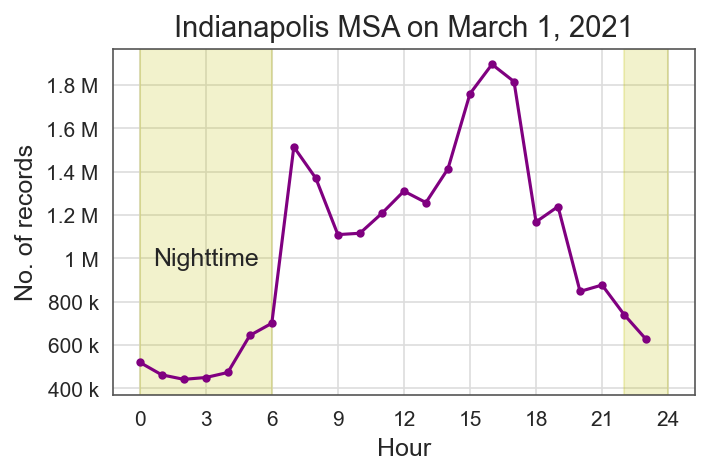

In [19]:
ax = U.plot(size=(5, 3), dpi=150, yeng=1, ylab='No. of records', gridcolor='#ddd',
            title='Indianapolis MSA on March 1, 2021', framebordercolor='#555')
x.set_index('hr').sort_index()['count'].plot(ax=ax, marker='.', color='purple')
ax.axvspan(0, 6, color='y', alpha=0.2)
ax.axvspan(22, 24, color='y', alpha=0.2)
ax.text(3, 1e6, 'Nighttime', ha='center', va='center', fontsize=12)
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xlabel('Hour')
P.imsave(title='Hourly ping count profile in Indianapolis')

### Data summary

In [21]:
indy.counts.join(SP.pdf2sdf(Pdf({'date': indy.dates})), on='date')

DataFrame[date: date, uid: bigint, slot: int, n_pings: int]

In [22]:
res = []
for rgn in tqdm([indy, aus, hous]):
    df = rgn.counts.join(SP.pdf2sdf(Pdf({'date': rgn.dates})), on='date')
    nUsers = df.select(F.col(UID)).toPandas()[UID].nunique() // 1e3
    nPings = df.agg(F.sum('n_pings')).collect()[0][0] // 1e6
    res.append({'City': rgn.name, 'Dates': f'{rgn.dates[0]} - {rgn.dates[-1]}',
                'No. of users (k)': int(nUsers), 'No. of pings (M)': int(nPings)})
Pdf(res)

  0%|          | 0/3 [00:00<?, ?it/s]

,City,Dates,No. of users (k),No. of pings (M)
0,Indianapolis,2021-03-01 - 2021-03-07,608,194
1,Austin,2021-07-01 - 2021-07-07,822,147
2,Houston,2021-07-01 - 2021-07-07,1975,477


## Data quality-quantity tradeoff matrix

### Specify dates of interest

In [23]:
indy.dates = U.dates('2021-03-01', '2021-03-07')
aus.dates = U.dates('2021-07-01', '2021-07-07')
hous.dates = U.dates('2021-07-01', '2021-07-07')

### Prepare tradeoff matrix

In [24]:
def get_quality_quantity_tradeoff_matrix(rgn, filt_dates=True):
    counts = (rgn.counts.groupby(UID, 'date').count()
              .withColumnRenamed('count', 'n_slots').toPandas())
    if filt_dates:
        counts = counts.merge(Pdf({'date': rgn.dates}), on='date')
    unique_users = counts[UID].unique()
    uids = Pdf({UID: unique_users}).rename_axis('user').reset_index()
    stats = counts.merge(uids, on=UID).drop(columns=UID)
    df = (stats.groupby(['user', 'n_slots']).size()
          .rename('n_days').reset_index()
          .sort_values('n_slots', ascending=False))
    df['cum_days'] = df.groupby('user')['n_days'].cumsum()
    df = df.sort_values(['user', 'n_slots'], ascending=[True, False])
    df = df.groupby(['n_slots','cum_days'])['user'].agg(set).reset_index()
    df['cell'] = [list(it.product(range(r['n_slots']), range(r['cum_days']))) 
                  for _, r in df.iterrows()]
    df = df.explode('cell').groupby('cell')['user'].apply(
        lambda x: len(set().union(*x))).rename('n_users').reset_index()
    df['n_slots'], df['n_days'] = list(zip(*df['cell']))
    df = df.pivot(index='n_days', columns='n_slots', values='n_users')
    df = df.fillna(0)
    df /= (len(unique_users) / 100)
    # df.index += 1; df.columns += 1
    return df

In [25]:
indy.qq_matrix = get_quality_quantity_tradeoff_matrix(indy).disp(None) # t=7s

7 rows x 48 cols; Memory: 0.0 MiB


n_slots,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
n_days,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,100.0,67.867569,54.777857,45.708542,38.922952,34.004221,30.122233,26.870147,24.232347,22.145548,20.440932,19.030555,17.839132,16.829512,15.958793,15.161881,14.428748,13.750518,13.085109,12.431372,11.779606,11.163019,10.537554,9.928528,9.320652,8.73957,8.169173,7.628857,7.137855,6.707674,6.327957,6.002321,5.731752,5.496689,5.29516,5.127164,4.983168,4.844267,4.715558,4.60904,4.499398,4.393045,4.282089,4.159461,4.01678,3.835305,3.594489,3.239593
1,57.66387,43.816861,36.419451,30.848133,26.660234,23.548528,21.10256,19.241783,17.784886,16.615819,15.646801,14.838382,14.118728,13.470579,12.858758,12.269129,11.677198,11.089705,10.517007,9.921459,9.31194,8.726749,8.180844,7.635761,7.126349,6.671346,6.247575,5.865886,5.562606,5.303379,5.08311,4.895882,4.741036,4.6023,4.483947,4.373648,4.268445,4.163242,4.022533,3.92144,3.819524,3.722047,3.616516,3.502765,3.360741,3.176471,2.920039,2.51172
2,41.173802,32.537626,27.219946,23.279439,20.35529,18.21441,16.614997,15.41782,14.44535,13.648109,13.007686,12.410167,11.854564,11.334138,10.81815,10.268794,9.724697,9.184217,8.638805,8.082709,7.549626,7.0532,6.569102,6.130537,5.731095,5.396089,5.09922,4.850349,4.640107,4.476221,4.331238,4.215186,4.114421,4.013492,3.913714,3.82462,3.731253,3.645939,3.555695,3.468903,3.382275,3.291044,3.181732,3.048748,2.890615,2.683497,2.393531,1.964007
3,32.900741,26.0877,21.79016,18.826067,16.766555,15.326261,14.233794,13.395622,12.700132,12.110009,11.564105,11.061432,10.543143,10.017457,9.492922,8.970359,8.439577,7.925891,7.400698,6.89145,6.411462,5.988184,5.60107,5.25538,4.956702,4.718681,4.511562,4.327786,4.186091,4.064779,3.952836,3.851907,3.762813,3.671254,3.5769,3.490272,3.400685,3.308797,3.222005,3.128637,3.031489,2.923984,2.806124,2.666237,2.481803,2.240987,1.945104,1.483526
4,26.746698,21.175709,17.881048,15.799016,14.392091,13.353212,12.575532,11.924918,11.347124,10.816999,10.310382,9.812969,9.305858,8.78461,8.258924,7.729622,7.233524,6.742029,6.276671,5.84501,5.474663,5.129959,4.823226,4.571068,4.363292,4.186913,4.035684,3.907796,3.800128,3.705445,3.60994,3.520847,3.430109,3.337563,3.242059,3.14902,3.050885,2.95423,2.854123,2.752372,2.643553,2.520926,2.383011,2.219782,2.013486,1.766752,1.480074,1.025893
5,20.783992,16.751103,14.587703,13.264776,12.282608,11.539941,10.907901,10.372353,9.871981,9.366843,8.871731,8.374647,7.864249,7.361576,6.880272,6.403407,5.956624,5.540579,5.176149,4.852979,4.577807,4.334854,4.116394,3.932618,3.789114,3.669446,3.565558,3.466766,3.366823,3.28151,3.19932,3.111541,3.02064,2.927108,2.830124,2.727715,2.623663,2.516159,2.408654,2.291123,2.166523,2.024006,1.878037,1.705438,1.501279,1.256189,0.979538,0.575822
6,15.0072,12.956236,11.735717,10.861711,10.177727,9.569194,9.027892,8.51174,8.008903,7.508367,7.031666,6.554636,6.100291,5.680795,5.287927,4.925963,4.59967,4.327293,4.09897,3.897112,3.728294,3.578708,3.444574,3.333783,3.23499,3.142609,3.055817,2.966065,2.873191,2.779495,2.680702,2.573527,2.468488,2.35934,2.242466,2.119182,1.997377,1.869325,1.742259,1.621769,1.489608,1.346105,1.201122,1.039372,0.855267,0.635163,0.399771,0.166517


In [26]:
aus.qq_matrix = get_quality_quantity_tradeoff_matrix(aus) # t=5s

In [27]:
hous.qq_matrix = get_quality_quantity_tradeoff_matrix(hous) # t=19s

### Plot tradeoff matrix

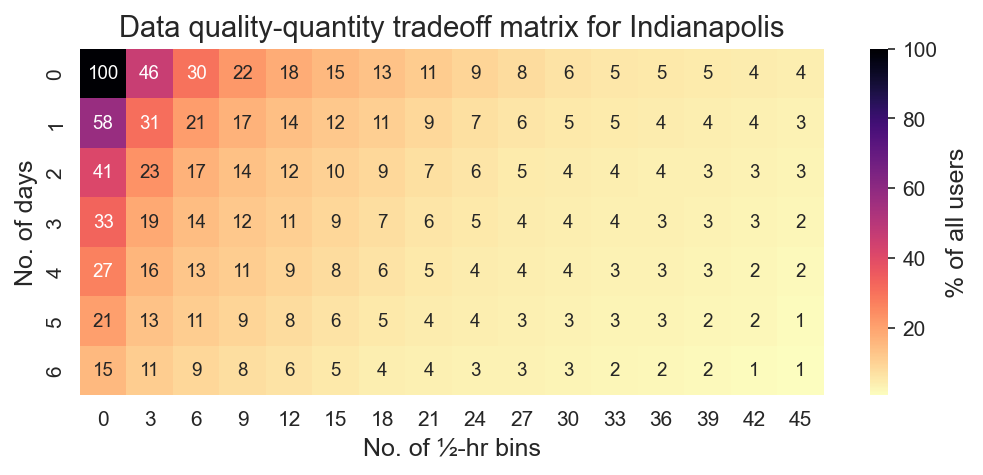

In [28]:
def plot_quality_quantity_tradeoff_matrix(
    rgn, slot_size=3, size=(8, 3), dpi=150,
    cmap='magma_r', annot_size=9
):
    # n_users = rgn.ustats[UID].nunique()
    mat = rgn.qq_matrix.loc[:, np.arange(0, 48, slot_size)]
    ax = U.plot(size=size, dpi=dpi)
    sns.heatmap(ax=ax, data=mat, cmap=cmap, annot=True,
                fmt='.0f', annot_kws=dict(fontsize=annot_size),
                cbar_kws=dict(label='% of all users'))
    U.plot(ax, xlab='No. of ½-hr bins', ylab='No. of days',
           title=f'Data quality-quantity tradeoff matrix for {rgn.name}')
    P.imsave()

plot_quality_quantity_tradeoff_matrix(indy)

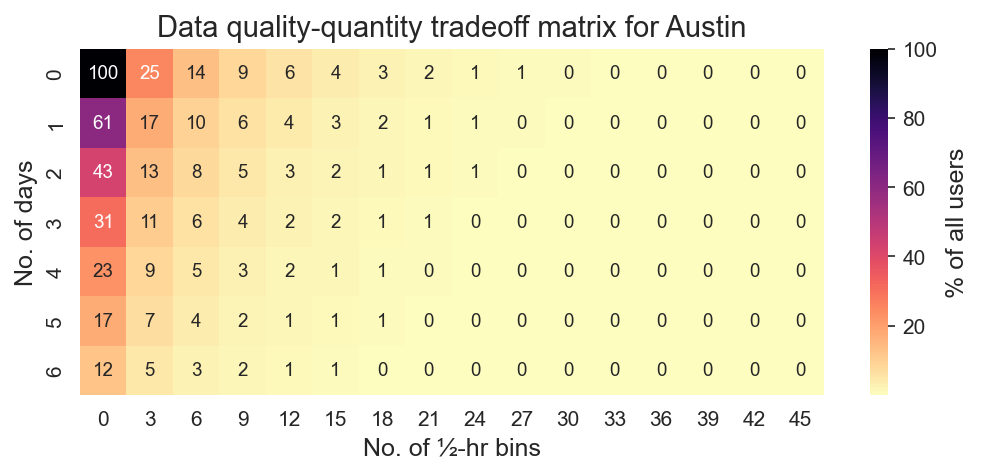

In [29]:
plot_quality_quantity_tradeoff_matrix(aus)

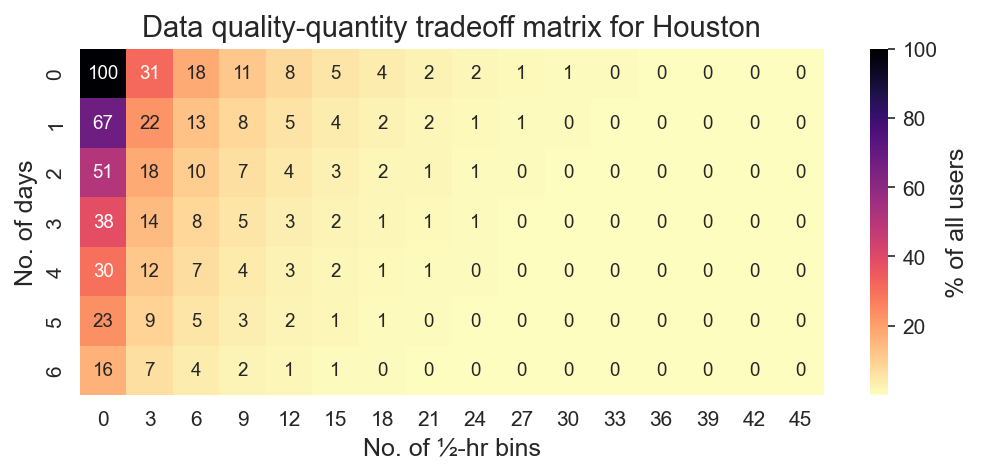

In [30]:
plot_quality_quantity_tradeoff_matrix(hous)

# Prepare night pings

## Parameters

In [40]:
# this parameter set means filtering nighttime data of users whose overall 
# nighttime data includes more than a minimum no. of pings
day_hrs = (6, 21) # 6 AM - 9 PM
min_pings = 20 # min pings for a user to be considered during the entire study period
# duration of slot (in seconds) for superping creation
slot_size = 1800 # 30 minutes

P.params.set({'pings': {'day_hours': dict(zip(['start', 'end'], day_hrs)),
                        'slot_size': slot_size, 'nighttime': {'min_pings': min_pings}}})

## Make pings
Filter all the pings only during the nighttime.

In [43]:
def get_nighttime_pings(rgn, day_hrs, min_pings, slot_size, filt_dates=True, save=False):
    dates = rgn.dates if filt_dates else pd.to_datetime(
        [x.stem for x in (rgn.data / 'pings').glob('*')]).date
    df = mk.gps.get_home_work_loc_data(
        SP, dates, root=rgn.data / 'pings',
        day_hrs=day_hrs, min_pings=min_pings)
    df = df.withColumn('slot', F.udf(lambda ts: [int(t / slot_size) for t in ts],
                                     T.array(T.int8))(TS)).drop(TS)
    if save:
        mk.spark.write(df, rgn.data / 'night_pings')
    return df

get_nighttime_pings(indy, day_hrs, min_pings, slot_size)

DataFrame[uid: bigint, day: smallint, lon: array<float>, lat: array<float>, slot: array<tinyint>]

In [ ]:
# %time _ = get_nighttime_pings(indy, day_hrs, min_pings, save=True) # t=1:57
# %time _ = get_nighttime_pings(aus, day_hrs, min_pings, save=True) # t=1:43
# %time _ = get_nighttime_pings(hous, day_hrs, min_pings, save=True) # t=4:51

## Make superpings
From the nighttime pings data, find the mean location and radius of gyration of each super-ping (collection of pings in each ½-hour slot).

**Radius of gyration** (taken from https://doi.org/10.1016/j.comnet.2014.02.011):

$$ r_g = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\vec{p}_i - \vec{p}_{centroid})^2} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} [(x_i - x_c)^2 + (y_i - y_c)^2]} = \sqrt{\text{var}(x) + \text{var}(y)} $$

In [45]:
def dist_deg2m(angle, lat, a=6_371_001, b=6_356_752):
    """ Convert angular distance from degrees to meters at given latitude. """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
        (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(curve_radius * np.deg2rad(angle))

In [46]:
def get_nighttime_superpings(rgn, save=False):
    xyt_cols = [LON, LAT, 'slot']
    df = SP.read_parquet(rgn.data / 'night_pings')
    df = df.select(UID, 'day', F.arrays_zip(*xyt_cols).alias('xyt'))
    df = df.select(UID, 'day', F.explode('xyt').alias('xyt'))
    df = df.select(UID, 'day', *[F.col('xyt')[x].alias(x) for x in xyt_cols])
    df = df.groupby(UID, 'day', 'slot').agg(
        *[F.collect_list(x).alias(x) for x in [LON, LAT]],
        *[F.mean(x).cast(T.float).alias('mean_' + x) for x in [LON, LAT]])
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def get_rg(x, y):
        return dist_deg2m(np.sqrt(np.std(x)**2 + np.std(y)**2), np.mean(y))
    df = df.withColumn('rg', F.udf(get_rg, T.float)(LON, LAT))
    df = df.select(UID, 'day', 'slot', 'n_pings', 'mean_'+LON, 'mean_'+LAT, 'rg')
    if save:
        mk.spark.write(df, rgn.data / 'night_superpings')
    return df
    
get_nighttime_superpings(indy)

DataFrame[uid: bigint, day: smallint, slot: tinyint, n_pings: smallint, mean_lon: float, mean_lat: float, rg: float]

In [ ]:
# %time _ = get_nighttime_superpings(indy, save=True) # t=21s
# %time _ = get_nighttime_superpings(aus, save=True) # t=9s
# %time _ = get_nighttime_superpings(hous, save=True) # t=24s

# Investigate

In [47]:
df = pd.read_parquet(indy.data / 'night_superpings').disp()

4,204,854 rows x 7 cols; Memory: 100.3 MiB


,uid,day,slot,n_pings,mean_lon,mean_lat,rg
,<int64>,<int16>,<int8>,<int16>,<float32>,<float32>,<float32>
0,-9223273625461784742,1,6,2,-85.911194,39.874294,0.598843


<AxesSubplot: >

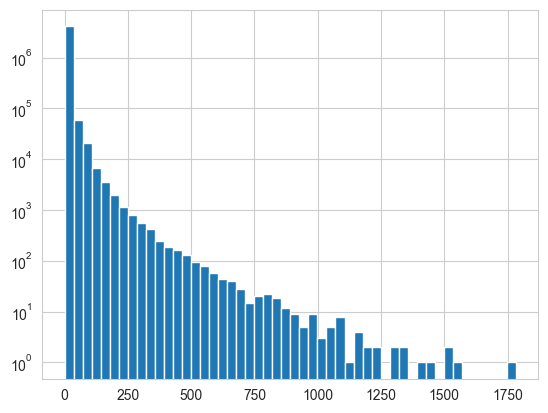

In [48]:
df.n_pings.hist(bins=50, ax=U.plot(ylog=1))

<AxesSubplot: >

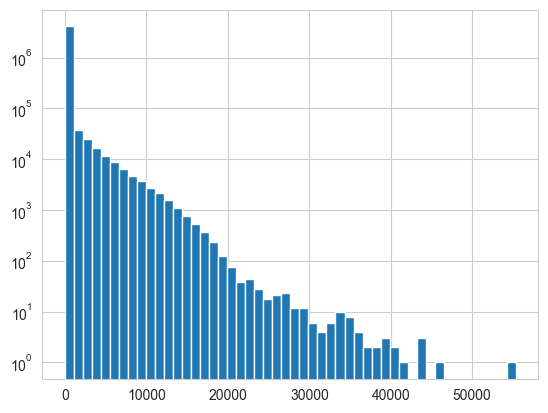

In [49]:
df.rg.hist(bins=50, ax=U.plot(ylog=1))

<AxesSubplot: >

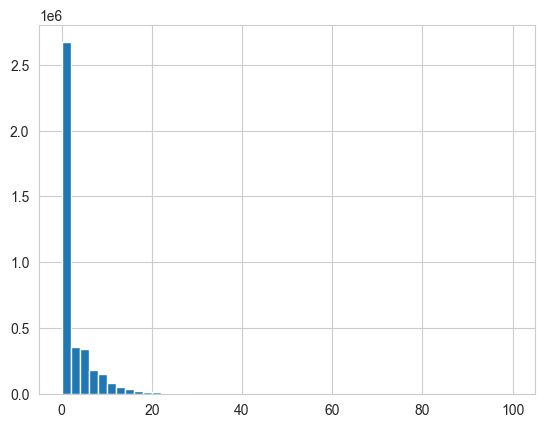

In [50]:
df.rg[df.rg < 100].hist(bins=50)

In [51]:
df.rg.max()

55360.26

In [52]:
df.slot.value_counts().sort_index()

0     239193
1     232914
2     231257
3     225553
4     226054
5     221403
6     221849
7     217973
8     219644
9     216989
10    223122
11    223708
12       722
42    260738
43    256140
44    257143
45    247839
46    241820
47    240793
Name: slot, dtype: int64

In [53]:
df.query('rg > 40000').sort_values('n_pings', ascending=False)

,uid,day,slot,n_pings,mean_lon,mean_lat,rg
3856137,3330900054778122638,3,11,88,-86.212730,39.774864,40655.707031
323157,-7783066272687254180,7,11,9,-85.963745,40.044106,41914.625000
1090950,-2403877343469132506,0,45,6,-86.143120,39.790443,43641.628906
523157,8693264680052732958,7,11,4,-86.196182,39.843384,55360.261719
3927855,-2403877343469132506,0,44,4,-86.029648,39.870731,46289.093750
101811,8711874080805320121,3,44,2,-86.304062,39.998779,43871.750000
309485,8223639275868130404,7,11,2,-86.048126,39.798103,40863.789062
1372852,-8232702994307703476,5,42,2,-86.102524,39.891891,44160.917969


In [54]:
x = SP.read_parquet(indy.data / 'pings/2021-03-04').filter('uid==3330900054778122638').toPandas().iloc[0]; x

uid                                    3330900054778122638
lon      [-85.62567, -85.62568, -85.62532, -85.62532, -...
lat      [39.56968, 39.56967, 39.5696, 39.5696, 39.5696...
ts       [339.0, 349.0, 1475.0, 1476.0, 1480.0, 1486.0,...
error    [13.8, 13.8, 20.2, 24.5, 20.2, 24.5, 19.4, 19....
Name: 0, dtype: object

In [55]:
import contextily as ctx

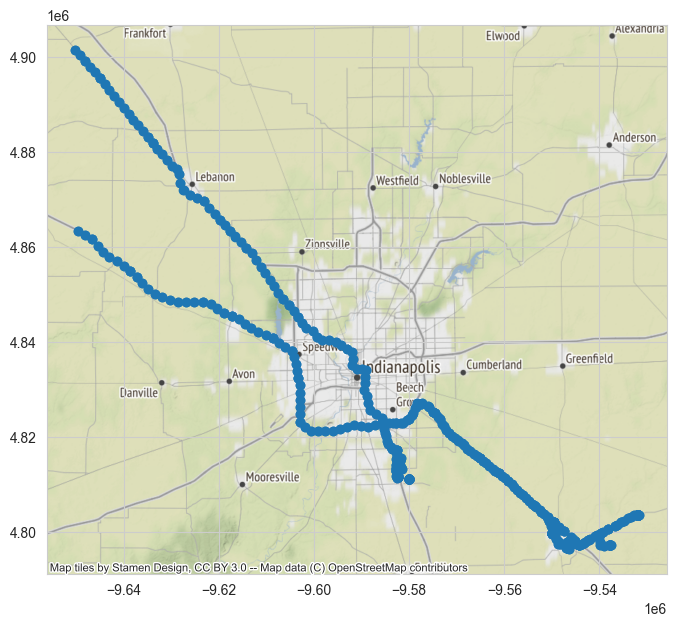

In [56]:
ax = U.plot(size=(8, 8), dpi=100)
mk.geo.pdf2gdf(Pdf({'x':x.lon,'y':x.lat}),'x','y',CRS_DEG).to_crs(CRS_M).plot(ax=ax)
ctx.add_basemap(ax=ax, crs=CRS_M);

In [57]:
df.day.value_counts()

1    618462
4    608768
5    601127
2    594454
3    590181
6    579457
7    391609
0    220796
Name: day, dtype: int64

23/03/09 17:40:19 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-66c2f596-f90d-466f-9167-a1d65f857239. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-66c2f596-f90d-466f-9167-a1d65f857239
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:171)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:110)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:91)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1206)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:374)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:370)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach